In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
import matplotlib.pyplot as plt
from keras import regularizers
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#train
#test
#load data
path = 'C:/Users/mys12/Desktop/northeastern/summer2018/data_Robust_Fingerprinting-master/DISTRIBUTED_OPENSOURCE/FINGERPRINTING_DB'

test_rss = pd.read_csv(path + '/Training_rss_21Aug17.csv', header = 0)
test_coord = pd.read_csv(path + '/Training_coordinates_21Aug17.csv', header = 0)
test_rss = test_rss.replace(100, 0)

train_rss = pd.read_csv(path + '/Test_rss_21Aug17.csv', header = 0)
train_coord = pd.read_csv(path + '/Test_coordinates_21Aug17.csv', header = 0)
train_rss = train_rss.replace(100, 0)


In [3]:
train = pd.concat([train_rss, train_coord], axis=1, ignore_index=True)
test = pd.concat([test_rss, test_coord], axis=1, ignore_index=True)
train = np.asarray(train)
test = np.asarray(test)

# first floor
train1 = train[train[:,-1]==0.0]
normalizer1 = preprocessing.Normalizer().fit(train1[:,:-3])
train1_r=normalizer1.transform(train1[:,:-3])
train1_c=train1[:,-3:-1]
print(train1_r.shape)

test1 = test[test[:,-1]==0.0]
test1_r=normalizer1.transform(test1[:,:-3])
test1_c=test1[:,-3:-1]

# second floor
train2 = train[train[:,-1]==3.7]
normalizer2 = preprocessing.Normalizer().fit(train2[:,:-3])
train2_r=normalizer2.transform(train2[:,:-3])
train2_c=train2[:,-3:-1]
print(train2_r.shape)

test2 = test[test[:,-1]==3.7]
test2_r=normalizer2.transform(test2[:,:-3])
test2_c=test2[:,-3:-1]

# third floor
train3 = train[train[:,-1]==7.4]
normalizer3 = preprocessing.Normalizer().fit(train3[:,:-3])
train3_r=normalizer3.transform(train3[:,:-3])
train3_c=train3[:,-3:-1]
print(train3_r.shape)

test3 = test[test[:,-1]==7.4]
test3_r=normalizer3.transform(test3[:,:-3])
test3_c=test3[:,-3:-1]

# Forth floor
train4 = train[train[:,-1]==11.1]
normalizer4 = preprocessing.Normalizer().fit(train4[:,:-3])
train4_r=normalizer4.transform(train4[:,:-3])
train4_c=train4[:,-3:-1]
print(train4_r.shape)

test4 = test[test[:,-1]==11.1]
test4_r=normalizer4.transform(test4[:,:-3])
test4_c=test4[:,-3:-1]

# Fifth floor
train5 = train[train[:,-1]==14.8]
normalizer5 = preprocessing.Normalizer().fit(train5[:,:-3])
train5_r=normalizer5.transform(train5[:,:-3])
train5_c=train5[:,-3:-1]
print(train5_r.shape)

test5 = test[test[:,-1]==14.8]
test5_r=normalizer5.transform(test5[:,:-3])
test5_c=test5[:,-3:-1]
print("test", test5_r.shape)

(1264, 992)
(1108, 992)
(770, 992)
(699, 992)
(109, 992)
test (17, 992)


In [4]:
def predata(rss, locations):
    # the origin of the room
    origin = np.amin(locations,axis=0)
    #size of the room
    room_size = np.amax(locations, axis=0)-origin
    # position respect to origin
    train_Yy = locations - origin
    train_Xx = np.asarray(rss, dtype=np.float64)
    return train_Xx, train_Yy

In [5]:
def train_val(rss, locations):
    train_Xx, train_Yy = predata(rss, locations)
    train_x, val_x, train_y, val_y = train_test_split(train_Xx, train_Yy, test_size=0.25)
    return train_x, val_x, train_y, val_y

In [6]:
def accuracy(predictions, labels):
    error = np.sqrt(np.sum((predictions - labels)**2, 1))
    return error, np.mean(error)

In [7]:
def encoder():
    model = Sequential()
    model.add(Dense(512, input_dim=input_size, activation='relu', bias=True))
    model.add(Dense(256, activation='relu', bias=True))
    #model.add(Dense(128, activation='relu', bias=True))
    return model

In [8]:
def decoder(e):   
    #e.add(Dense(256, input_dim=128, activation='relu', bias=True))
    e.add(Dense(512, input_dim=256, activation='relu', bias=True))
    e.add(Dense(input_size, activation='relu', bias=True))
    e.compile(optimizer='adam', loss='mse')
    return e

In [9]:
def regression(d):
    num_to_remove = 2
    regularzation_penalty = 0.02
    initilization_method = 'he_normal' #'random_uniform' ,'random_normal','TruncatedNormal' ,'glorot_uniform', 'glorot_nomral', 'he_normal', 'he_uniform'
    #Optimizer
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    for i in range(num_to_remove):
        d.pop()
    d.add(Dense(256, input_dim=256, activation='relu', kernel_initializer=initilization_method, kernel_regularizer=regularizers.l2(regularzation_penalty)))
    d.add(Dropout(0.5))
    d.add(Dense(128, activation='relu', kernel_initializer=initilization_method, kernel_regularizer=regularizers.l2(regularzation_penalty)))
    d.add(Dropout(0.5))
    d.add(Dense(num_classes, activation='linear', kernel_initializer=initilization_method, kernel_regularizer=regularizers.l2(regularzation_penalty)))

    #Model compile
    d.compile(loss='mean_squared_error',
                  optimizer='adam')
    
    return d

In [13]:
nb_epochs = 500
# batch_size = 64
input_size = 992
num_classes = 2
# np.random.seed(5)

In [14]:
def train_model(train_r, train_c, test_r, test_c, batch_size):
    train_X, val_X, train_Y, val_Y = train_val(train_r, train_c)
    test_X, test_Y = predata(test_r, test_c)
    e = encoder()
    d = decoder(e)
    d.fit(train_X, train_X, nb_epoch=nb_epochs, batch_size=batch_size)
    
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')
    Model_best= keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

    c = regression(d)
    c.fit(train_X, train_Y, validation_data=(val_X, val_Y), nb_epoch=nb_epochs, callbacks=[earlyStopping, Model_best], batch_size=batch_size)
    
    #model evaluate
    train_loss = c.evaluate(train_X,train_Y, batch_size=len(train_Y)) #calculate the data in test mode(Keras)
    val_loss = c.evaluate(val_X, val_Y, batch_size=len(val_Y))
    test_loss = c.evaluate(test_X, test_Y, batch_size=len(test_Y))
#     print("Loss for training data is",train_loss)
#     print("Loss for validation data is",val_loss)
#     print("Loss for test data is",test_loss)
    predict_Y = c.predict(test_X)
    error, accuracy1 = accuracy(predict_Y, test_Y)
    
    # PDF figure
    error_sorted= np.sort(error)
    p = 1. *np.arange(len(error))/(len(error)-1)
    plt.plot(error_sorted, p)
    plt.show()
    return error, accuracy1
    

C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=992, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  after removing the cwd from sys.path.
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=256, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(992, activation="relu", use_bias=True)`
  after re

Epoch 1/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 2/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 3/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 4/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 5/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 6/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 7/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 8/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 9/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 10/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 11/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 12/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 13/500
948/948 [==============================] - 0s - 

948/948 [==============================] - 0s - loss: 0.0010     
Epoch 207/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 208/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 209/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 210/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 211/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 212/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 213/500
948/948 [==============================] - 0s - loss: 0.0010     - ETA: 0s - loss: 0.00
Epoch 214/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 215/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 216/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 217/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 218/500
948/948 [=========

948/948 [==============================] - 0s - loss: 0.0010     
Epoch 411/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 412/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 413/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 414/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 415/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 416/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 417/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 418/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 419/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 420/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 421/500
948/948 [==============================] - 0s - loss: 0.0010     
Epoch 422/500
948/948 [==============================]

948/948 [==============================] - 0s - loss: 86.9566 - val_loss: 76.7184
Epoch 96/500
948/948 [==============================] - 0s - loss: 86.9244 - val_loss: 70.3203
Epoch 97/500
948/948 [==============================] - 0s - loss: 81.9759 - val_loss: 70.7994
Epoch 98/500
948/948 [==============================] - 0s - loss: 79.1252 - val_loss: 69.4726
Epoch 99/500
948/948 [==============================] - 0s - loss: 92.2170 - val_loss: 89.3701
Epoch 100/500
948/948 [==============================] - 0s - loss: 82.6204 - val_loss: 67.2903
Epoch 101/500
948/948 [==============================] - 0s - loss: 87.1594 - val_loss: 63.2741
Epoch 102/500
948/948 [==============================] - 0s - loss: 82.7371 - val_loss: 66.5880
Epoch 103/500
948/948 [==============================] - 0s - loss: 80.6351 - val_loss: 92.9359
Epoch 104/500
948/948 [==============================] - 0s - loss: 78.5993 - val_loss: 69.0004
Epoch 105/500
948/948 [==============================] - 0

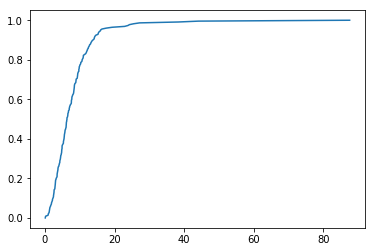

In [20]:
error1, accuracy1 = train_model(train1_r, train1_c, test1_r, test1_c)


In [21]:
print(accuracy1)

7.93273276116


C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=992, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  after removing the cwd from sys.path.
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=256, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(992, activation="relu", use_bias=True)`
  after re

Epoch 1/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 2/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 3/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 4/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 5/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 6/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 7/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 8/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 9/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 10/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 11/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 12/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 13/500
831/831 [==============================] - 0s - 

831/831 [==============================] - 0s - loss: 0.0010     
Epoch 105/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 106/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 107/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 108/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 109/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 110/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 111/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 112/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 113/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 114/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 115/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 116/500
831/831 [==============================]

831/831 [==============================] - 0s - loss: 0.0010     
Epoch 207/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 208/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 209/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 210/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 211/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 212/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 213/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 214/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 215/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 216/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 217/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 218/500
831/831 [==============================]

831/831 [==============================] - 0s - loss: 0.0010     
Epoch 308/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 309/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 310/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 311/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 312/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 313/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 314/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 315/500
831/831 [==============================] - 0s - loss: 0.0010     - ETA: 0s - loss
Epoch 316/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 317/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 318/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 319/500
831/831 [===============

831/831 [==============================] - 0s - loss: 0.0010     
Epoch 410/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 411/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 412/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 413/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 414/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 415/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 416/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 417/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 418/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 419/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 420/500
831/831 [==============================] - 0s - loss: 0.0010     
Epoch 421/500
831/831 [==============================]

831/831 [==============================] - 0s - loss: 376.4082 - val_loss: 171.4578
Epoch 10/500
831/831 [==============================] - 0s - loss: 299.5358 - val_loss: 109.0845
Epoch 11/500
831/831 [==============================] - 0s - loss: 277.8172 - val_loss: 123.2353
Epoch 12/500
831/831 [==============================] - 0s - loss: 283.9943 - val_loss: 108.3716
Epoch 13/500
831/831 [==============================] - 0s - loss: 262.8538 - val_loss: 98.8009
Epoch 14/500
831/831 [==============================] - 0s - loss: 242.3879 - val_loss: 100.7939
Epoch 15/500
831/831 [==============================] - 0s - loss: 241.4971 - val_loss: 96.1547
Epoch 16/500
831/831 [==============================] - 0s - loss: 246.5561 - val_loss: 78.8233
Epoch 17/500
831/831 [==============================] - 0s - loss: 241.6506 - val_loss: 80.7754
Epoch 18/500
831/831 [==============================] - 0s - loss: 230.1129 - val_loss: 77.5799
Epoch 19/500
831/831 [==========================

831/831 [==============================] - 0s - loss: 153.1352 - val_loss: 60.5795
Epoch 95/500
831/831 [==============================] - 0s - loss: 166.4466 - val_loss: 81.4511
Epoch 96/500
831/831 [==============================] - 0s - loss: 164.4634 - val_loss: 77.3471
Epoch 97/500
831/831 [==============================] - 0s - loss: 167.6003 - val_loss: 75.1435
Epoch 98/500
831/831 [==============================] - 0s - loss: 172.8051 - val_loss: 62.8367
Epoch 99/500
831/831 [==============================] - 0s - loss: 153.0245 - val_loss: 62.3343
Epoch 100/500
831/831 [==============================] - 0s - loss: 185.2093 - val_loss: 89.2593
Epoch 101/500
831/831 [==============================] - 0s - loss: 175.9830 - val_loss: 68.1812
Epoch 102/500
831/831 [==============================] - 0s - loss: 161.1015 - val_loss: 84.9212
Epoch 103/500
831/831 [==============================] - 0s - loss: 183.3610 - val_loss: 77.4398
Epoch 104/500
831/831 [==========================

831/831 [==============================] - 0s - loss: 143.7818 - val_loss: 75.0413
Epoch 179/500
831/831 [==============================] - 0s - loss: 150.7225 - val_loss: 54.3654
Epoch 180/500
831/831 [==============================] - 0s - loss: 147.5691 - val_loss: 56.6237
Epoch 181/500
831/831 [==============================] - 0s - loss: 135.1545 - val_loss: 56.6050
Epoch 182/500
831/831 [==============================] - 0s - loss: 154.7751 - val_loss: 57.6950
Epoch 183/500
831/831 [==============================] - 0s - loss: 149.8894 - val_loss: 83.2909
Epoch 184/500
831/831 [==============================] - 0s - loss: 153.7525 - val_loss: 60.4593
Epoch 185/500
831/831 [==============================] - 0s - loss: 132.7684 - val_loss: 57.0650
Epoch 186/500
831/831 [==============================] - 0s - loss: 143.8427 - val_loss: 58.3558
Epoch 187/500
831/831 [==============================] - 0s - loss: 139.5017 - val_loss: 52.4019
Epoch 188/500
831/831 [=====================

831/831 [==============================] - 0s - loss: 131.7349 - val_loss: 75.4574
Epoch 263/500
831/831 [==============================] - 0s - loss: 135.9853 - val_loss: 58.0074
Epoch 264/500
831/831 [==============================] - 0s - loss: 138.6731 - val_loss: 65.3257
Epoch 265/500
831/831 [==============================] - 0s - loss: 130.8639 - val_loss: 71.9703
Epoch 266/500
831/831 [==============================] - 0s - loss: 138.0090 - val_loss: 56.8917
Epoch 267/500
831/831 [==============================] - 0s - loss: 133.8099 - val_loss: 51.2067
Epoch 268/500
831/831 [==============================] - 0s - loss: 137.9886 - val_loss: 57.8607
Epoch 269/500
831/831 [==============================] - 0s - loss: 125.1787 - val_loss: 55.2823
Epoch 270/500
831/831 [==============================] - 0s - loss: 132.6176 - val_loss: 57.8460
Epoch 271/500
831/831 [==============================] - 0s - loss: 135.3095 - val_loss: 69.6314
Epoch 272/500
831/831 [=====================

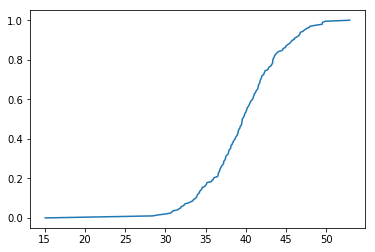

39.5474202475


In [15]:
error2, accuracy2 = train_model(train2_r, train2_c, test2_r, test2_c, batch_size = 32)
print(accuracy2)

C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=992, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  after removing the cwd from sys.path.
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=256, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(992, activation="relu", use_bias=True)`
  after re

Epoch 1/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 2/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 3/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 4/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 5/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 6/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 7/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 8/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 9/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 10/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 11/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 12/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 13/500
577/577 [==============================] - 0s - 

577/577 [==============================] - 0s - loss: 0.0010     
Epoch 105/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 106/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 107/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 108/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 109/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 110/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 111/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 112/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 113/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 114/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 115/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 116/500
577/577 [==============================]

577/577 [==============================] - 0s - loss: 0.0010     
Epoch 207/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 208/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 209/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 210/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 211/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 212/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 213/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 214/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 215/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 216/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 217/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 218/500
577/577 [==============================]

577/577 [==============================] - 0s - loss: 0.0010     
Epoch 309/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 310/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 311/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 312/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 313/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 314/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 315/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 316/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 317/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 318/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 319/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 320/500
577/577 [==============================]

577/577 [==============================] - 0s - loss: 0.0010     
Epoch 411/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 412/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 413/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 414/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 415/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 416/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 417/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 418/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 419/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 420/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 421/500
577/577 [==============================] - 0s - loss: 0.0010     
Epoch 422/500
577/577 [==============================]

577/577 [==============================] - 0s - loss: 335.1257 - val_loss: 199.5648
Epoch 11/500
577/577 [==============================] - 0s - loss: 309.0638 - val_loss: 206.8401
Epoch 12/500
577/577 [==============================] - 0s - loss: 313.1664 - val_loss: 189.4723
Epoch 13/500
577/577 [==============================] - 0s - loss: 297.6695 - val_loss: 213.9747
Epoch 14/500
577/577 [==============================] - 0s - loss: 294.9861 - val_loss: 184.0325
Epoch 15/500
577/577 [==============================] - 0s - loss: 289.5396 - val_loss: 189.4909
Epoch 16/500
577/577 [==============================] - 0s - loss: 299.4818 - val_loss: 216.9643
Epoch 17/500
577/577 [==============================] - 0s - loss: 291.3906 - val_loss: 179.9913
Epoch 18/500
577/577 [==============================] - 0s - loss: 297.0897 - val_loss: 194.2976
Epoch 19/500
577/577 [==============================] - 0s - loss: 312.1540 - val_loss: 248.0796
Epoch 20/500
577/577 [=====================

577/577 [==============================] - 0s - loss: 151.2087 - val_loss: 64.5980
Epoch 96/500
577/577 [==============================] - 0s - loss: 136.9984 - val_loss: 81.9783
Epoch 97/500
577/577 [==============================] - 0s - loss: 138.5407 - val_loss: 70.4829
Epoch 98/500
577/577 [==============================] - 0s - loss: 157.3391 - val_loss: 109.9181
Epoch 99/500
577/577 [==============================] - 0s - loss: 145.8995 - val_loss: 88.8270
Epoch 100/500
577/577 [==============================] - 0s - loss: 141.2011 - val_loss: 69.1329
Epoch 101/500
577/577 [==============================] - 0s - loss: 142.0253 - val_loss: 79.0843
Epoch 102/500
577/577 [==============================] - 0s - loss: 129.8810 - val_loss: 72.5264
Epoch 103/500
577/577 [==============================] - 0s - loss: 145.9833 - val_loss: 93.0492
Epoch 104/500
577/577 [==============================] - 0s - loss: 159.0904 - val_loss: 76.5794
Epoch 105/500
577/577 [========================

577/577 [==============================] - 0s - loss: 252.8566 - val_loss: 184.9087
Epoch 180/500
577/577 [==============================] - 0s - loss: 178.9746 - val_loss: 76.7345
Epoch 181/500
577/577 [==============================] - 0s - loss: 150.3571 - val_loss: 64.5456
Epoch 182/500
577/577 [==============================] - 0s - loss: 146.5465 - val_loss: 107.8358
Epoch 183/500
577/577 [==============================] - 0s - loss: 142.4356 - val_loss: 69.7115
Epoch 184/500
577/577 [==============================] - 0s - loss: 132.5873 - val_loss: 97.8321
Epoch 185/500
577/577 [==============================] - 0s - loss: 152.1165 - val_loss: 71.1924
Epoch 186/500
577/577 [==============================] - 0s - loss: 120.4836 - val_loss: 70.2629
Epoch 187/500
138/138 [==============================] - 0s


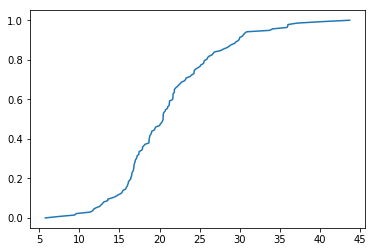

21.0550114407


In [12]:
error3, accuracy3 = train_model(train3_r, train3_c, test3_r, test3_c, batch_size = 32)
print(accuracy3)

C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=992, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  after removing the cwd from sys.path.
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=256, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(992, activation="relu", use_bias=True)`
  after re

Epoch 1/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 2/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 3/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 4/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 5/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 6/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 7/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 8/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 9/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 10/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 11/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 12/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 13/500
524/524 [==============================] - 0s - 

524/524 [==============================] - 0s - loss: 0.0010     
Epoch 207/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 208/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 209/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 210/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 211/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 212/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 213/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 214/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 215/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 216/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 217/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 218/500
524/524 [==============================]

524/524 [==============================] - 0s - loss: 0.0010     
Epoch 411/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 412/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 413/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 414/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 415/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 416/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 417/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 418/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 419/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 420/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 421/500
524/524 [==============================] - 0s - loss: 0.0010     
Epoch 422/500
524/524 [==============================]

524/524 [==============================] - 0s - loss: 249.6140 - val_loss: 177.6814
Epoch 11/500
524/524 [==============================] - 0s - loss: 243.5716 - val_loss: 163.9794
Epoch 12/500
524/524 [==============================] - 0s - loss: 221.9614 - val_loss: 174.5175
Epoch 13/500
524/524 [==============================] - 0s - loss: 228.3684 - val_loss: 162.5003
Epoch 14/500
524/524 [==============================] - 0s - loss: 227.3853 - val_loss: 161.9260
Epoch 15/500
524/524 [==============================] - 0s - loss: 219.0936 - val_loss: 156.4078
Epoch 16/500
524/524 [==============================] - 0s - loss: 216.2280 - val_loss: 147.5120
Epoch 17/500
524/524 [==============================] - 0s - loss: 230.1590 - val_loss: 167.2829
Epoch 18/500
524/524 [==============================] - 0s - loss: 210.0719 - val_loss: 162.6207
Epoch 19/500
524/524 [==============================] - 0s - loss: 201.0612 - val_loss: 139.7628
Epoch 20/500
524/524 [=====================

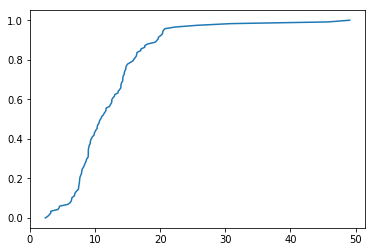

12.2987768508


In [24]:
error4, accuracy4 = train_model(train4_r, train4_c, test4_r, test4_c)
print(accuracy4)

C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=992, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  after removing the cwd from sys.path.
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=256, activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\software\WinPython\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(992, activation="relu", use_bias=True)`
  after re

Epoch 1/500
81/81 [==============================] - 0s - loss: 0.0011     
Epoch 2/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 3/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 4/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 5/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 6/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 7/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 8/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 9/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 10/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 11/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 12/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 13/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 14

81/81 [==============================] - 0s - loss: 0.0010     
Epoch 108/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 109/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 110/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 111/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 112/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 113/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 114/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 115/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 116/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 117/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 118/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 119/500
81/81 [==============================] - 0s - loss: 0.0010     


81/81 [==============================] - 0s - loss: 0.0010     
Epoch 316/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 317/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 318/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 319/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 320/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 321/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 322/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 323/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 324/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 325/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 326/500
81/81 [==============================] - 0s - loss: 0.0010     
Epoch 327/500
81/81 [==============================] - 0s - loss: 0.0010     


81/81 [==============================] - 0s - loss: 316.4163 - val_loss: 358.1738
Epoch 21/500
81/81 [==============================] - 0s - loss: 284.5454 - val_loss: 286.9667
Epoch 22/500
81/81 [==============================] - 0s - loss: 264.0265 - val_loss: 229.0078
Epoch 23/500
81/81 [==============================] - 0s - loss: 263.4727 - val_loss: 199.0521
Epoch 24/500
81/81 [==============================] - 0s - loss: 259.2731 - val_loss: 189.2958
Epoch 25/500
81/81 [==============================] - 0s - loss: 262.7939 - val_loss: 188.3051
Epoch 26/500
81/81 [==============================] - 0s - loss: 231.2920 - val_loss: 196.3294
Epoch 27/500
81/81 [==============================] - 0s - loss: 214.2296 - val_loss: 212.1852
Epoch 28/500
81/81 [==============================] - 0s - loss: 224.0892 - val_loss: 221.9530
Epoch 29/500
81/81 [==============================] - 0s - loss: 229.4380 - val_loss: 222.1991
Epoch 30/500
81/81 [==============================] - 0s - loss

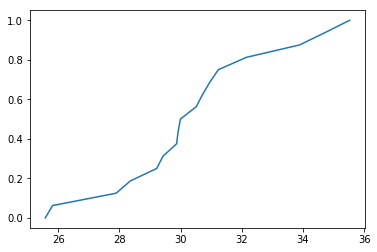

30.3419504043


In [25]:
error5, accuracy5 = train_model(train5_r, train5_c, test5_r, test5_c)
print(accuracy5)

In [26]:
np.mean([accuracy1,accuracy2,accuracy3,accuracy4,accuracy5])

22.12746067262243

In [8]:
print(np.mean([3,4,5]))

4.0


In [22]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=4)
clf2 = neigh.fit(train2_r, train2_c)
predict2 = clf2.predict(test2_r)
error2, mean2 = accuracy(predict2,test2_c)
print(mean2)


6.07182594675


In [17]:
accuracy(predict2, test2_c)

(array([  2.76288831,   1.65808579,  11.2930501 ,   8.2015466 ,
         10.29101527,   4.83482606,   2.77502955,   1.11162505,
          3.66367808,   4.26955528,  14.76690361,  12.36903735,
          2.89121537,   3.90534147,   4.60482693,   3.29176519,
          7.80278572,   5.08835926,   5.02890873,   4.22594535,
         25.39332457,   8.13728085,   1.88252613,   3.15834435,
          7.36856976,  13.58891521,  11.54284249,   4.5671567 ,
          4.28113508,   5.87602703,   6.6101125 ,   8.57073558,
          2.72110575,   4.47037208,   7.77809715,   5.1543221 ,
         18.82938149,  15.00264987,   7.24690986,   1.95555018,
          5.45809764,   0.61340627,   2.09292829,   0.35802621,
         19.63221759,   2.20028231,   3.54024452,  11.54405282,
         12.93377219,   8.57995322,   2.29919634,   8.57931743,
          2.5253895 ,   4.69077678,   3.63527238,  29.75396835,
          2.74816335,   2.14686811,   2.64417005,  15.0614139 ,
          5.21755069,  11.4696757 ,   8.

In [18]:

neigh3 = KNeighborsRegressor(n_neighbors=4)
clf3 = neigh3.fit(train3_r, train3_c)
predict3 = clf3.predict(test3_r)
error3, mean3 = accuracy(predict3,test3_c)
print(mean3)


7.13739485549


In [19]:
neigh4 = KNeighborsRegressor(n_neighbors=4)
clf4 = neigh3.fit(train4_r, train4_c)
predict4 = clf4.predict(test4_r)
error4, mean4 = accuracy(predict4,test4_c)
print(mean4)

6.86356084694


In [20]:
neigh5 = KNeighborsRegressor(n_neighbors=4)
clf5 = neigh3.fit(train5_r, train5_c)
predict5 = clf5.predict(test5_r)
error5, mean5 = accuracy(predict5,test5_c)
print(mean5)

2.42057132458


In [21]:
neigh1 = KNeighborsRegressor(n_neighbors=4)
clf1 = neigh1.fit(train1_r, train1_c)
predict1 = clf1.predict(test1_r)
error1, mean1 = accuracy(predict1,test1_c)
print(mean1)

6.63646363652


In [23]:
np.mean([mean1,mean2,mean3,mean4,mean5])

5.8259633220559284